# Make all necessary imports

In [119]:
# Path, directory
import glob
import os

# Parsing
import requests
from bs4 import BeautifulSoup

# Math, time, regular expressions
import re
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import math
from pprint import pprint

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

# CatBoost
from catboost import CatBoostRegressor

## Setup

In [2]:
RANDOM_SEED = 42
VAL_SIZE = 0.2

In [3]:
# MAPE function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
sample_submission = pd.read_csv('sample_submission.csv')

# 1. Initial data and parcing

In [4]:
# Let's take a look on test data
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [5]:
# Take the car brands used in test datase for further parsing filter
brands = test.brand.value_counts()
brand_dict = {brands.index[i]: brands[i] for i in range(len(brands))}
brand_dict

{'BMW': 4473,
 'VOLKSWAGEN': 4404,
 'NISSAN': 4393,
 'MERCEDES': 4180,
 'TOYOTA': 3913,
 'AUDI': 3421,
 'MITSUBISHI': 2843,
 'SKODA': 2741,
 'VOLVO': 1463,
 'HONDA': 1150,
 'INFINITI': 871,
 'LEXUS': 834}

## Parsing part

In [6]:
# Here the code to parse data from auto.ru for brands taken in test dataset

# for brand in brand_dict:  # brand
#     car_data = []
#     for i in range(1, 100):  # number of pages is limited to 99
#         response = requests.get(f'https://auto.ru/cars/{brand}/used/?output_type=list&page={i}')
#         if response.status_code != 200:
#             raise BaseException("response code" + str(response.status_code))
#         response.encoding = 'utf-8'
#         soup = BeautifulSoup(response.text, 'html.parser')
#         page = soup.find_all('div', class_='ListingItem-module__description')
#         for item in page:
#             options = {}
#             try:
#                 options.update(
#                     {'bodyType': item.find_all('div', class_='ListingItemTechSummaryDesktop__cell')[2].text})
#             except IndexError:
#                 options.update(
#                     {'bodyType': np.nan})
#             options.update(
#                 {'brand': brand})
#             try:
#                 options.update(
#                     {'color': item.find_all('div', class_='ListingItemTechSummaryDesktop__cell')[4].text})
#             except IndexError:
#                 options.update(
#                     {'color': np.nan})
#             try:
#                 options.update(
#                     {'model': item.find_all('a', class_='Link ListingItemTitle-module__link')[0].text})
#             except IndexError:
#                 options.update(
#                     {'model': np.nan})
#             try:
#                 options.update(
#                     {'engine': item.find_all('div', class_='ListingItemTechSummaryDesktop__cell')[0].text.replace('\u2009', '').replace('\xa0', ' ')})
#             except IndexError:
#                 options.update(
#                     {'engine': np.nan})
#             try:
#                 options.update(
#                     {'vehicleTransmission': item.find_all('div', class_='ListingItemTechSummaryDesktop__cell')[1].text})
#             except IndexError:
#                 options.update(
#                     {'vehicleTransmission': np.nan})
#             try:
#                 options.update(
#                     {'modelDate': item.find_all('div', class_='ListingItem-module__year')[0].text})
#             except IndexError:
#                 options.update(
#                     {'modelDate': np.nan})
#             try:
#                 options.update(
#                     {'Привод': item.find_all('div', class_='ListingItemTechSummaryDesktop__cell')[3].text})
#             except IndexError:
#                 options.update(
#                     {'Привод': np.nan})
#             try:
#                 options.update(
#                     {'mileAge': item.find_all('div', class_='ListingItem-module__kmAge')[0].text.replace('\xa0', '')[:-2]})
#             except IndexError:
#                 options.update(
#                     {'mileAge': np.nan})
#             try:
#                 options.update(
#                     {'Руль': item.find_all('div', class_='ListingItemState-module__item')[0].text.replace('\xa0', '')[:7]})
#             except IndexError:
#                 options.update(
#                     {'Руль': 'Левый'})
#             try:
#                 options.update(
#                     {'price': item.find_all('div', class_='ListingItemPrice-module__content')[0].text.replace(u'\xa0', '')[:-1]})
#             except IndexError:
#                 options.update(
#                     {'price': item.find_all('span')[0].text.replace(u'\xa0', '')[:-1]})

#             car_data.append(options)
#     df = pd.DataFrame(car_data)
#     df = df[df['price'].apply(lambda x: len(x) < 18)] # limit if parsing gets wrong
#     df.to_csv(brand+ '.csv')

In [7]:
# Additionally the data was parsed for 5 more brands, let's combine them all in common brand list
brand_list = []
for i in brand_dict:
    brand_list.append(i)
brand_list.extend(['KIA', 'CHEVROLET', 'FORD', 'HYUNDAI', 'RENAULT'])
brand_list

['BMW',
 'VOLKSWAGEN',
 'NISSAN',
 'MERCEDES',
 'TOYOTA',
 'AUDI',
 'MITSUBISHI',
 'SKODA',
 'VOLVO',
 'HONDA',
 'INFINITI',
 'LEXUS',
 'KIA',
 'CHEVROLET',
 'FORD',
 'HYUNDAI',
 'RENAULT']

In [8]:
# Combine files in one dataframe
folder_name = 'parsing_2'
file_type = 'csv'
seperator =','
df = pd.concat([pd.read_csv(f, sep=seperator) for f in glob.glob(folder_name + "/*."+file_type)],ignore_index=True)
df = df.drop(columns=['Unnamed: 0'])
df.drop_duplicates()
df

,bodyType,brand,color,model,engine,vehicleTransmission,modelDate,Привод,mileAge,Руль,price
0,внедорожник 5 дв.,AUDI,красный,Audi Q3 I (8U),2.0 л/170 л.с./Бензин,робот,2014,полный,39672,Левый,1590000
1,внедорожник 5 дв.,AUDI,белый,Audi Q3 I (8U),2.0 л/211 л.с./Бензин,робот,2012,полный,104500,Левый,1050000
2,внедорожник 5 дв.,AUDI,чёрный,Audi Q7 I (4L) Рестайлинг,5.9 л/500 л.с./Дизель,автомат,2011,полный,78000,Левый,2799000
3,внедорожник 5 дв.,AUDI,чёрный,Audi Q8 I 55 TFSI,3.0 л/340 л.с./Бензин,автомат,2018,полный,21464,Левый,5652000
4,лифтбек,AUDI,чёрный,Audi A5 Sportback I (8T) Рестайлинг,2.0 л/225 л.с./Бензин,робот,2015,полный,111500,Левый,1265000
...,...,...,...,...,...,...,...,...,...,...,...
121731,внедорожник 5 дв.,VOLVO,коричневый,Volvo XC60 I,2.4 л/163 л.с./Дизель,автомат,2012,полный,67000,Левый,1239000
121732,внедорожник 5 дв.,VOLVO,коричневый,Volvo XC60 I,2.0 л/203 л.с./Бензин,робот,2010,передний,120620,Левый,919000
121733,универсал 5 дв.,VOLVO,бежевый,Volvo XC70 II,2.4 л/163 л.с./Дизель,автомат,2012,полный,135677,Левый,1320000
121734,внедорожник 5 дв.,VOLVO,зелёный,Volvo XC60 II,2.0 л/190 л.с./Дизель,автомат,2018,полный,92917,Левый,2648000


# 2. Data preprocessing

In [9]:
# Take a look on data we have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121736 entries, 0 to 121735
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             121734 non-null  object
 1   brand                121736 non-null  object
 2   color                121734 non-null  object
 3   model                121736 non-null  object
 4   engine               121736 non-null  object
 5   vehicleTransmission  121734 non-null  object
 6   modelDate            121736 non-null  int64 
 7   Привод               121734 non-null  object
 8   mileAge              121736 non-null  int64 
 9   Руль                 121736 non-null  object
 10  price                121736 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 10.2+ MB


In [10]:
for i in df.columns:
    print(df[f'{i}'].value_counts())

внедорожник 5 дв.          54230
седан                      37036
хэтчбек 5 дв.               8783
лифтбек                     6010
минивэн                     4468
универсал 5 дв.             3508
купе                        2842
компактвэн                  2084
пикап двойная кабина        1115
хэтчбек 3 дв.                891
внедорожник 3 дв.            231
кабриолет                    210
фургон                       103
купе-хардтоп                  75
родстер                       52
микровэн                      26
пикап полуторная кабина       23
пикап одинарная кабина        18
седан 2 дв.                   10
седан-хардтоп                  9
хэтчбек 4 дв.                  5
фастбек                        2
внедорожник открытый           1
универсал 3 дв.                1
тарга                          1
Name: bodyType, dtype: int64
TOYOTA        7363
NISSAN        7363
CHEVROLET     7363
AUDI          7363
VOLKSWAGEN    7363
HONDA         7363
FORD          7363
BMW          

Here Engine column should be splitted by 3 to get with test dataframe better. We also have some electro cars with unusual vehicleTransmission value like 'Заряд на ..' I will count them all as automatic transmission, because there is no manual electro cars at all.

In [11]:
# Drop NaN first
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121734 entries, 0 to 121735
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             121734 non-null  object
 1   brand                121734 non-null  object
 2   color                121734 non-null  object
 3   model                121734 non-null  object
 4   engine               121734 non-null  object
 5   vehicleTransmission  121734 non-null  object
 6   modelDate            121734 non-null  int64 
 7   Привод               121734 non-null  object
 8   mileAge              121734 non-null  int64 
 9   Руль                 121734 non-null  object
 10  price                121734 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 11.1+ MB


In [12]:
# Split engine column
df[['engineDisplacement','enginePower','fuelType']] = df.engine.str.split("/",expand=True)


C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
# For electric cars we have engine power in displacement and test data doesn't consist of any displacements for 
# electric cars. Let's correct it
df.loc[(df.fuelType == 'Электро'),'enginePower'] = df['engineDisplacement']


C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
# Check what we got not
df[df['fuelType']=='Электро'].enginePower

47        408 л.с. 
290       313 л.с. 
719       408 л.с. 
1588      503 л.с. 
2224      408 л.с. 
            ...    
109741    115 л.с. 
110919    115 л.с. 
111249    136 л.с. 
111317    115 л.с. 
111509    115 л.с. 
Name: enginePower, Length: 144, dtype: object

In [15]:
# Replace whole engineDisplacement column for electric cars with 'LTR'
df.loc[(df.fuelType == 'Электро'),'engineDisplacement'] = 'LTR'

C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [16]:
# Replace 'л' with 'LTR' in engineDisplacement and replace 'л.с.' with 'N12' in enginePower
df['engineDisplacement'] = df['engineDisplacement'].str.replace('л','LTR')
df['enginePower'] = df['enginePower'].str.replace('л.с.', 'N12')

# Replace 'Заряд на...' with 'автомат' and other values according its names in test dataframe
df.loc[df['vehicleTransmission'].str.contains('Заряд'), 'vehicleTransmission'] = 'автоматическая'
df['vehicleTransmission'] = df['vehicleTransmission'].str.replace('автомат','автоматическая')
df['vehicleTransmission'] = df['vehicleTransmission'].str.replace('механика','механическая')
df['vehicleTransmission'] = df['vehicleTransmission'].str.replace('робот','роботизированная')

for i in df.columns:
    print(df[f'{i}'].value_counts())

<ipython-input-16-614f8b6d9341>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['engineDisplacement'] = df['engineDisplacement'].str.replace('л','LTR')
<ipython-input-16-614f8b6d9341>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['enginePower'] = df['enginePower'].str.replace('л.с.', 'N12')
<ipython-input-16-614f8b6d9341>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

внедорожник 5 дв.          54230
седан                      37036
хэтчбек 5 дв.               8783
лифтбек                     6010
минивэн                     4468
универсал 5 дв.             3508
купе                        2842
компактвэн                  2084
пикап двойная кабина        1115
хэтчбек 3 дв.                891
внедорожник 3 дв.            231
кабриолет                    210
фургон                       103
купе-хардтоп                  75
родстер                       52
микровэн                      26
пикап полуторная кабина       23
пикап одинарная кабина        18
седан 2 дв.                   10
седан-хардтоп                  9
хэтчбек 4 дв.                  5
фастбек                        2
внедорожник открытый           1
универсал 3 дв.                1
тарга                          1
Name: bodyType, dtype: int64
TOYOTA        7363
KIA           7363
CHEVROLET     7363
AUDI          7363
VOLKSWAGEN    7363
FORD          7363
NISSAN        7363
BMW          

In [17]:
# Drop engine column
df = df.drop('engine', axis=1)
df

,bodyType,brand,color,model,vehicleTransmission,modelDate,Привод,mileAge,Руль,price,engineDisplacement,enginePower,fuelType
0,внедорожник 5 дв.,AUDI,красный,Audi Q3 I (8U),роботизированная,2014,полный,39672,Левый,1590000,2.0 LTR,170 N12,Бензин
1,внедорожник 5 дв.,AUDI,белый,Audi Q3 I (8U),роботизированная,2012,полный,104500,Левый,1050000,2.0 LTR,211 N12,Бензин
2,внедорожник 5 дв.,AUDI,чёрный,Audi Q7 I (4L) Рестайлинг,автоматическая,2011,полный,78000,Левый,2799000,5.9 LTR,500 N12,Дизель
3,внедорожник 5 дв.,AUDI,чёрный,Audi Q8 I 55 TFSI,автоматическая,2018,полный,21464,Левый,5652000,3.0 LTR,340 N12,Бензин
4,лифтбек,AUDI,чёрный,Audi A5 Sportback I (8T) Рестайлинг,роботизированная,2015,полный,111500,Левый,1265000,2.0 LTR,225 N12,Бензин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121731,внедорожник 5 дв.,VOLVO,коричневый,Volvo XC60 I,автоматическая,2012,полный,67000,Левый,1239000,2.4 LTR,163 N12,Дизель
121732,внедорожник 5 дв.,VOLVO,коричневый,Volvo XC60 I,роботизированная,2010,передний,120620,Левый,919000,2.0 LTR,203 N12,Бензин
121733,универсал 5 дв.,VOLVO,бежевый,Volvo XC70 II,автоматическая,2012,полный,135677,Левый,1320000,2.4 LTR,163 N12,Дизель
121734,внедорожник 5 дв.,VOLVO,зелёный,Volvo XC60 II,автоматическая,2018,полный,92917,Левый,2648000,2.0 LTR,190 N12,Дизель


In [18]:
# Add vendor column to train dataset
eur = ['BMW', 'VOLKSWAGEN', 'MERCEDES', 'AUDI', 'SKODA', 'VOLVO']
df['vendor'] = df['brand'].apply(lambda x: 'EUROPEAN' if x in eur else 'JAPANESE')

In [19]:
# Rename column modelDate as productionDate and other minor changes in column names according to test data
df = df.rename(columns={'modelDate': 'productionDate','mileAge': 'mileage','model': 'model_name'})

# And rearrange them to place 'price' on last position
df = df [['bodyType', 'brand', 'color', 'model_name', 'vehicleTransmission',
       'productionDate', 'Привод', 'mileage', 'Руль',
       'engineDisplacement', 'enginePower', 'fuelType', 'vendor', 'price']]
df.columns

Index(['bodyType', 'brand', 'color', 'model_name', 'vehicleTransmission',
       'productionDate', 'Привод', 'mileage', 'Руль', 'engineDisplacement',
       'enginePower', 'fuelType', 'vendor', 'price'],
      dtype='object')

In [20]:
# Keep in test dataframe only those column which are in train dataframe (except price)
test = test[df.columns.tolist()[:-1]]
test

,bodyType,brand,color,model_name,vehicleTransmission,productionDate,Привод,mileage,Руль,engineDisplacement,enginePower,fuelType,vendor
0,лифтбек,SKODA,синий,OCTAVIA,роботизированная,2014,передний,74000,Левый,1.2 LTR,105 N12,бензин,EUROPEAN
1,лифтбек,SKODA,чёрный,OCTAVIA,механическая,2017,передний,60563,Левый,1.6 LTR,110 N12,бензин,EUROPEAN
2,лифтбек,SKODA,серый,SUPERB,роботизированная,2014,передний,88000,Левый,1.8 LTR,152 N12,бензин,EUROPEAN
3,лифтбек,SKODA,коричневый,OCTAVIA,автоматическая,2014,передний,95000,Левый,1.6 LTR,110 N12,бензин,EUROPEAN
4,лифтбек,SKODA,белый,OCTAVIA,автоматическая,2012,передний,58536,Левый,1.8 LTR,152 N12,бензин,EUROPEAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,коричневый,3ER,автоматическая,2014,задний,115000,Левый,1.6 LTR,136 N12,бензин,EUROPEAN
34682,седан,BMW,чёрный,5ER,автоматическая,2018,полный,98000,Левый,2.0 LTR,190 N12,дизель,EUROPEAN
34683,седан,BMW,серый,5ER,автоматическая,1997,задний,360000,Левый,2.5 LTR,170 N12,бензин,EUROPEAN
34684,внедорожник 5 дв.,BMW,коричневый,X1,автоматическая,2013,полный,90500,Левый,2.0 LTR,184 N12,дизель,EUROPEAN


Couple more corrections left to make the datasets in the same format: chage fuelType to lower cases and correct  model_name train as well.

In [21]:
# Lower cases correction 
df['fuelType'] = df['fuelType'].str.lower()

In [22]:
# Model_name correction: keep model name only and apply uppercase
df['model_name'] = df['model_name'].apply(lambda x: (x.split(' ')[1]).upper())
df['model_name']

0           Q3
1           Q3
2           Q7
3           Q8
4           A5
          ... 
121731    XC60
121732    XC60
121733    XC70
121734    XC60
121735    XC90
Name: model_name, Length: 121734, dtype: object

In [23]:
# Make comparison with test dataset 
display(np.sort(test[test.brand == 'BMW'].model_name.unique()),
        np.sort(df[df.brand == 'BMW'].model_name.unique()))

array(['02', '1ER', '2ACTIVETOURER', '2ER', '2GRANDTOURER', '321', '326',
       '340', '3ER', '4', '5ER', '6ER', '7ER', '8ER', 'E3', 'I3', 'I8',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'X1', 'X2', 'X3', 'X3_M', 'X4',
       'X4_M', 'X5', 'X5_M', 'X6', 'X6_M', 'X7', 'Z1', 'Z3', 'Z3M', 'Z4'],
      dtype=object)

array(['02', '1', '2', '2000', '3', '321', '4', '5', '6', '7', '8', 'I3',
       'I8', 'M2', 'M3', 'M4', 'M5', 'M6', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'Z1', 'Z3', 'Z4', 'Z8'], dtype=object)

In [24]:
# Still some differneces for BMW. Let's cut models names starting with number in test dataset
num_list = ['1','2','3','4','5','6','7','8','9']
test['model_name'] = test['model_name'].apply(lambda x: x[0] if x[0] in num_list else x)

In [25]:
# Remove _M symbol for BMW models
test['model_name'] = test['model_name'].apply(lambda x: x[:2] if x[-2:] == '_M' else x)

In [26]:
display(np.sort(test[test.brand == 'BMW'].model_name.unique()),
        np.sort(df[df.brand == 'BMW'].model_name.unique()))

array(['02', '1', '2', '3', '4', '5', '6', '7', '8', 'E3', 'I3', 'I8',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'Z1', 'Z3', 'Z3M', 'Z4'], dtype=object)

array(['02', '1', '2', '2000', '3', '321', '4', '5', '6', '7', '8', 'I3',
       'I8', 'M2', 'M3', 'M4', 'M5', 'M6', 'X1', 'X2', 'X3', 'X4', 'X5',
       'X6', 'X7', 'Z1', 'Z3', 'Z4', 'Z8'], dtype=object)

Looks much better now!

In [27]:
# Check for couple more brands
display(np.sort(test[test.brand == 'MERCEDES'].model_name.unique()),
        np.sort(df[df.brand == 'MERCEDES'].model_name.unique()))

array(['1', 'AMG_GLC_COUPE', 'AMG_GT', 'A_KLASSE', 'A_KLASSE_AMG',
       'B_KLASSE', 'CITAN', 'CLA_KLASSE', 'CLA_KLASSE_AMG', 'CLC_KLASSE',
       'CLK_KLASSE', 'CLS_KLASSE', 'CLS_KLASSE_AMG', 'CL_KLASSE',
       'CL_KLASSE_AMG', 'C_KLASSE', 'C_KLASSE_AMG', 'E_KLASSE',
       'E_KLASSE_AMG', 'GLA_CLASS', 'GLA_CLASS_AMG', 'GLB_KLASSE',
       'GLC_COUPE', 'GLC_KLASSE', 'GLC_KLASSE_AMG', 'GLE_KLASSE',
       'GLE_KLASSE_AMG', 'GLE_KLASSE_COUPE', 'GLE_KLASSE_COUPE_AMG',
       'GLK_KLASSE', 'GLS_KLASSE', 'GLS_KLASSE_AMG', 'GL_KLASSE',
       'GL_KLASSE_AMG', 'G_KLASSE', 'G_KLASSE_AMG', 'MAYBACH_GLS',
       'M_KLASSE', 'M_KLASSE_AMG', 'R_KLASSE', 'SIMPLEX', 'SLC_KLASSE',
       'SLK_KLASSE', 'SLR_KLASSE', 'SLS_AMG', 'SL_KLASSE',
       'SL_KLASSE_AMG', 'S_CLASS_MAYBACH', 'S_KLASSE', 'S_KLASSE_AMG',
       'VANEO', 'VIANO', 'VITO', 'V_KLASSE', 'W111', 'W114', 'W123',
       'W124', 'W128', 'W136', 'W186', 'W188', 'W201', 'X_KLASSE'],
      dtype=object)

array(['190', 'A-КЛАСС', 'AMG', 'B-КЛАСС', 'C-КЛАСС', 'CITAN', 'CL-КЛАСС',
       'CLA', 'CLK-КЛАСС', 'CLS', 'E-КЛАСС', 'EQC', 'G-КЛАСС', 'GL-КЛАСС',
       'GLA', 'GLB', 'GLC', 'GLE', 'GLK-КЛАСС', 'GLS', 'M-КЛАСС',
       'MAYBACH', 'METRIS', 'R-КЛАСС', 'S-КЛАСС', 'SL-КЛАСС', 'SLC',
       'SLK-КЛАСС', 'SLR', 'SLS', 'V-КЛАСС', 'VIANO', 'VITO', 'W114',
       'W115', 'W123', 'W124', 'W128', 'W188', 'X-КЛАСС'], dtype=object)

In [28]:
# Generally looks similar but let's shortage names like 'AMG_GT'
df['model_name'] = df['model_name'].apply(lambda x: x.split('-')[0])
test['model_name'] = test['model_name'].apply(lambda x: x.split('_')[0])

In [29]:
display(np.sort(test[test.brand == 'MERCEDES'].model_name.unique()),
        np.sort(df[df.brand == 'MERCEDES'].model_name.unique()))

array(['1', 'A', 'AMG', 'B', 'C', 'CITAN', 'CL', 'CLA', 'CLC', 'CLK',
       'CLS', 'E', 'G', 'GL', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS',
       'M', 'MAYBACH', 'R', 'S', 'SIMPLEX', 'SL', 'SLC', 'SLK', 'SLR',
       'SLS', 'V', 'VANEO', 'VIANO', 'VITO', 'W111', 'W114', 'W123',
       'W124', 'W128', 'W136', 'W186', 'W188', 'W201', 'X'], dtype=object)

array(['190', 'A', 'AMG', 'B', 'C', 'CITAN', 'CL', 'CLA', 'CLK', 'CLS',
       'E', 'EQC', 'G', 'GL', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS',
       'M', 'MAYBACH', 'METRIS', 'R', 'S', 'SL', 'SLC', 'SLK', 'SLR',
       'SLS', 'V', 'VIANO', 'VITO', 'W114', 'W115', 'W123', 'W124',
       'W128', 'W188', 'X'], dtype=object)

In [30]:
# General check for all brands
display(np.sort(test.model_name.unique()),
        np.sort(df.model_name.unique()))

array(['02', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'A1', 'A2',
       'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'ACCORD', 'ACTY', 'AD',
       'AIRTREK', 'AIRWAVE', 'ALLEX', 'ALLROAD', 'ALMERA', 'ALPHARD',
       'ALTEZZA', 'ALTIMA', 'AMAROK', 'AMG', 'AQUA', 'ARISTO', 'ARMADA',
       'ARTEON', 'ASCOT', 'ASPIRE', 'ASX', 'ATLAS', 'AURIS', 'AVALON',
       'AVANCIER', 'AVENIR', 'AVENSIS', 'AYGO', 'B', 'BASSARA', 'BB',
       'BEETLE', 'BLADE', 'BLUEBIRD', 'BORA', 'C', 'C30', 'C70', 'CADDY',
       'CALDINA', 'CALIFORNIA', 'CAMI', 'CAMRY', 'CARAVAN', 'CARAVELLE',
       'CARINA', 'CARISMA', 'CAVALIER', 'CEDRIC', 'CEFIRO', 'CELICA',
       'CHARIOT', 'CHASER', 'CITAN', 'CITY', 'CIVIC', 'CL', 'CLA', 'CLC',
       'CLIPPER', 'CLK', 'CLS', 'COLT', 'CONCERTO', 'COROLLA', 'CORONA',
       'CORRADO', 'CORSA', 'COUPE', 'CR', 'CRESTA', 'CROSSROAD',
       'CROSSTOUR', 'CROWN', 'CT', 'CUBE', 'CURREN', 'CYNOS', 'DATSUN',
       'DAYZ', 'DELICA', 'DIAMANTE', 'DINGO', 'DION', 'DOMANI', 'DUET',
 

array(['02', '1', '100', '105,', '1200', '19', '190', '2', '200', '2000',
       '200SX', '240', '280ZX', '3', '300', '3000', '300ZX', '321',
       '350Z', '370Z', '4', '440', '460', '4RUNNER', '5', '6', '7', '740',
       '760', '8', '80', '850', '9', '90', '920', '940', '960', 'A', 'A1',
       'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'ACCENT', 'ACCORD',
       'ACTY', 'AD', 'AEROSTAR', 'AIRTREK', 'AIRWAVE', 'ALERO', 'ALLEX',
       'ALLION', 'ALMERA', 'ALPHARD', 'ALTEZZA', 'ALTIMA', 'AMAROK',
       'AMG', 'AQUA', 'ARISTO', 'ARKANA', 'ARMADA', 'ARTEON', 'ASCOT',
       'ASPIRE', 'ASTRO', 'ASX', 'AURIS', 'AVALANCHE', 'AVALON',
       'AVANCIER', 'AVANTE', 'AVANTIME', 'AVENIR', 'AVENSIS', 'AVEO',
       'AYGO', 'B', 'BB', 'BEAT', 'BEETLE', 'BEL', 'BLAZER', 'BLUEBIRD',
       'BOLT', 'BORA', 'BRONCO', 'C', 'C30', 'C70', 'CADDY', 'CALDINA',
       'CALIFORNIA', 'CAMARO', 'CAMI', 'CAMRY', 'CAPA', 'CAPRI',
       'CAPRICE', 'CAPTIVA', 'CAPTUR', 'CARAVAN', 'CARAVELLE', 'CARENS',
       '

In [31]:
# Additionally I would replace 'LTR' and 'N12' for engine columns in both datasets with '' and make these columns numeric in the future
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: x[:-4])
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:-4])

df['enginePower'] = df['enginePower'].apply(lambda x: x[:-4])
test['enginePower'] = test['enginePower'].apply(lambda x: x[:-4])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121734 entries, 0 to 121735
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             121734 non-null  object
 1   brand                121734 non-null  object
 2   color                121734 non-null  object
 3   model_name           121734 non-null  object
 4   vehicleTransmission  121734 non-null  object
 5   productionDate       121734 non-null  int64 
 6   Привод               121734 non-null  object
 7   mileage              121734 non-null  int64 
 8   Руль                 121734 non-null  object
 9   engineDisplacement   121734 non-null  object
 10  enginePower          121734 non-null  object
 11  fuelType             121734 non-null  object
 12  vendor               121734 non-null  object
 13  price                121734 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 18.9+ MB


## Outliers 

In [32]:
# Remove outliers with z score for numeric columns
# from scipy import stats
# df=df[(np.abs(stats.zscore(df[['productionDate', 'mileage', 'price']])) < 3).all(axis=1)]

In [33]:
# NOT TO REMOVE OUTLIERS, IT GIVES BETTER MAPE, BUT SUBMISSION IS WORSE, BECASUE WE HAVE TO SUBMIT THE SAME NUMBER AS
# IN SAMPLE AND IF I REMOVE OUTLIERS IT WILL NOT CATCH, FOR EXAMPLE, OLD CARS IN SAMPLE!

In [34]:
# Now combine datasets for EDA and mark train and test parts
columns = ['bodyType', 'brand', 'color', 'model_name', 'vehicleTransmission',
       'productionDate', 'Привод', 'mileage', 'Руль',
       'engineDisplacement', 'enginePower', 'fuelType', 'vendor']
cars_train = df[columns]
cars_test = test[columns]

y = df['price']

In [35]:
cars_train['sample'] = 1
cars_test['sample'] = 0
cars = cars_train.append(cars_test, ignore_index=True, sort=False)

# 3. EDA 

Some columns like engineDisplacement and enginePower have zero values after cutting which should be replaced

In [36]:
# For engineDisplacement let's replace them with average 2.5
cars['engineDisplacement'] = cars['engineDisplacement'].apply(lambda x: '2.5' if x == '' else x)

In [37]:
# And make these 2 columns numeric as discussed before
cars['enginePower'] = cars['enginePower'].apply(lambda x: int(x))
cars['engineDisplacement'] = cars['engineDisplacement'].apply(
                                                    lambda x: int(x.replace('.', '')))
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156420 entries, 0 to 156419
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             156420 non-null  object
 1   brand                156420 non-null  object
 2   color                156420 non-null  object
 3   model_name           156420 non-null  object
 4   vehicleTransmission  156420 non-null  object
 5   productionDate       156420 non-null  int64 
 6   Привод               156420 non-null  object
 7   mileage              156420 non-null  int64 
 8   Руль                 156420 non-null  object
 9   engineDisplacement   156420 non-null  int64 
 10  enginePower          156420 non-null  int64 
 11  fuelType             156420 non-null  object
 12  vendor               156420 non-null  object
 13  sample               156420 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 16.7+ MB


In [38]:
# Forgot to make replacement for columns with 'russian' name, let's do it here
cars = cars.rename(columns={'Привод': 'drive_unit','Руль': 'wheel'})
columns = ['bodyType', 'brand', 'color', 'model_name', 'vehicleTransmission',
       'productionDate', 'drive_unit', 'mileage', 'wheel',
       'engineDisplacement', 'enginePower', 'fuelType', 'vendor']

In [39]:
# Define numeric and categorical columns
num_col =['productionDate', 'mileage','engineDisplacement', 'enginePower']
cat_col = [x for x in columns if x not in num_col]

## 3.1 Numeric columns

C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


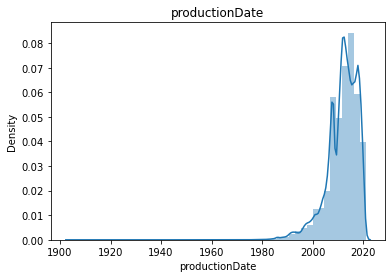

C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


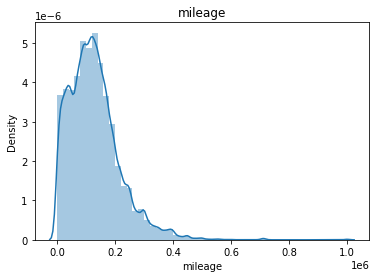

C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


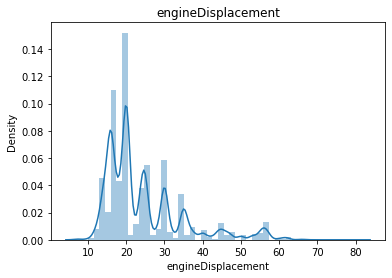

C:\Users\victor.kovatsenko\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


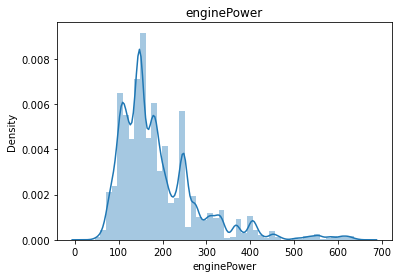

In [40]:
for i in num_col:
    plt.figure()
    sns.distplot(cars[i])
    plt.title(i)
    plt.show()

<AxesSubplot:>

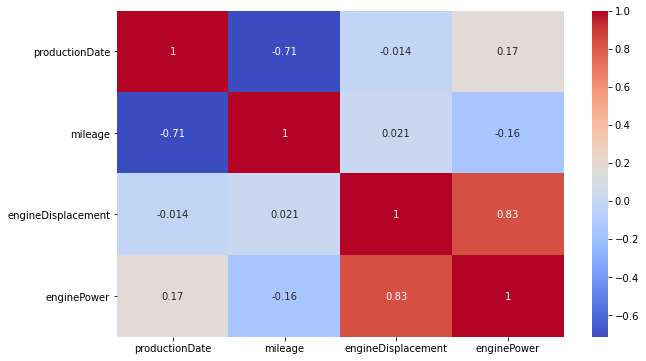

In [41]:
correlation = cars[num_col].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

All numeric variables have long tails which should be cutted in the future (or not if it affects model's quality negatively). High correlations between mileage and production date as well as engine displacement and power were expected. Based on it we can create new features later and probably remove one of highly correlated columns.

## 3.2 Categorical variables

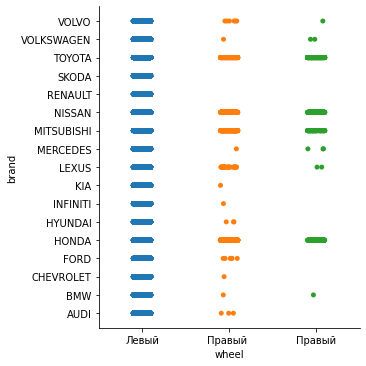

In [42]:
# Let's make plots for most interesting categorical variables
# For example which prands has right wheel models?
sns.catplot(x="wheel", y="brand", data=cars)

In [43]:
# As we can see Skoda nad Renault don't produce any right wheel cars, but apparantly data consists 2 different names for "Правый"
cars.wheel.value_counts()

Левый      151834
Правый       3187
Правый       1399
Name: wheel, dtype: int64

In [44]:
# Let's correct this (remove space)
cars['wheel'] = cars['wheel'].replace('Правый ', 'Правый')
cars.wheel.value_counts()

Левый     151834
Правый      4586
Name: wheel, dtype: int64

In [45]:
# Do check for other variables
for col in cat_col:
    print(cars[col].value_counts())

внедорожник 5 дв.          66458
седан                      50183
хэтчбек 5 дв.              10907
лифтбек                     8242
минивэн                     5463
универсал 5 дв.             4784
купе                        3666
компактвэн                  2573
пикап двойная кабина        1395
хэтчбек 3 дв.               1376
внедорожник 3 дв.            346
кабриолет                    300
купе-хардтоп                 233
фургон                       200
родстер                      151
микровэн                      33
пикап полуторная кабина       28
пикап одинарная кабина        23
седан-хардтоп                 21
седан 2 дв.                   16
лимузин                        6
хэтчбек 4 дв.                  5
внедорожник открытый           4
фастбек                        3
тарга                          3
универсал 3 дв.                1
Name: bodyType, dtype: int64
BMW           11836
VOLKSWAGEN    11767
NISSAN        11756
MERCEDES      11543
TOYOTA        11276
AUDI         

In [46]:
# One mistake in vehicleTransmission to correct
cars['vehicleTransmission'] = cars['vehicleTransmission'].replace('автоматическаяическая', 'автоматическая')
cars.vehicleTransmission.value_counts()

автоматическая      90459
механическая        34530
роботизированная    15916
вариатор            15515
Name: vehicleTransmission, dtype: int64

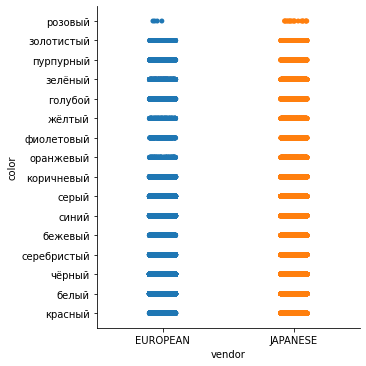

In [47]:
# Continue with plots
# Which vendor has more colored cars?
sns.catplot(x="vendor", y="color", data=cars)

All vendors have similar cars' colors, but rare color like pink is more cmmon for Japanese cars. There is no need to build plot between each categorical variables, just makes no sence. Generally we can say that disperssion between values in color or bodyType is very high, for other variables it's appropriate.

# 4. Feature engineering

There are some new features come in mind which might improve model and remove correlation between variables as well:
1. Add premium brand binary
2. Add mileage per year column
3. Combine productionDate and enginePower using polinominal features

In [48]:
# Premium column
cars['premium'] = cars['brand'].apply(lambda x: 1 if x in ['BMW','AUDI','MERCEDES','LEXUS','INFINITI'] else 0)
cat_col.append('premium')

In [49]:
# Mileage per year (use 2022 because if a car was made in 2021 I assume it as 1 year car)
cars['mileage_per_year'] = (cars['mileage']/(2022 - cars['productionDate'])).astype('int64')
num_col.append('mileage_per_year')

In [50]:
# Polinominal features
poly = PolynomialFeatures(2)
poly_features = poly.fit_transform(cars[['productionDate', 'enginePower']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,5], axis = 1) # keep the column which shows product (date*power) 
poly.columns = ['date_power_product']
    
cars = pd.concat([cars, poly], axis=1)
cars

,bodyType,brand,color,model_name,vehicleTransmission,productionDate,drive_unit,mileage,wheel,engineDisplacement,enginePower,fuelType,vendor,sample,premium,mileage_per_year,date_power_product
0,внедорожник 5 дв.,AUDI,красный,Q3,роботизированная,2014,полный,39672,Левый,20,170,бензин,EUROPEAN,1,1,4959,342380.0
1,внедорожник 5 дв.,AUDI,белый,Q3,роботизированная,2012,полный,104500,Левый,20,211,бензин,EUROPEAN,1,1,10450,424532.0
2,внедорожник 5 дв.,AUDI,чёрный,Q7,автоматическая,2011,полный,78000,Левый,59,500,дизель,EUROPEAN,1,1,7090,1005500.0
3,внедорожник 5 дв.,AUDI,чёрный,Q8,автоматическая,2018,полный,21464,Левый,30,340,бензин,EUROPEAN,1,1,5366,686120.0
4,лифтбек,AUDI,чёрный,A5,роботизированная,2015,полный,111500,Левый,20,225,бензин,EUROPEAN,1,1,15928,453375.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156415,седан,BMW,коричневый,3,автоматическая,2014,задний,115000,Левый,16,136,бензин,EUROPEAN,0,1,14375,273904.0
156416,седан,BMW,чёрный,5,автоматическая,2018,полный,98000,Левый,20,190,дизель,EUROPEAN,0,1,24500,383420.0
156417,седан,BMW,серый,5,автоматическая,1997,задний,360000,Левый,25,170,бензин,EUROPEAN,0,1,14400,339490.0
156418,внедорожник 5 дв.,BMW,коричневый,X1,автоматическая,2013,полный,90500,Левый,20,184,дизель,EUROPEAN,0,1,10055,370392.0


In [51]:
# Update num columns
num_col.append('date_power_product')

<AxesSubplot:>

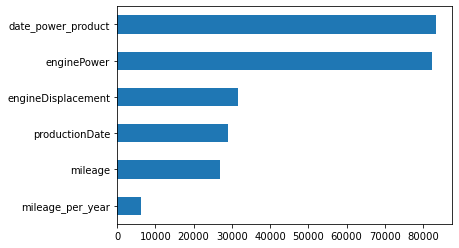

In [52]:
# Check significancy using F-value:
num_col_test = pd.Series(f_regression(cars[cars['sample'] == 1][num_col], y)[0], index = num_col)
num_col_test.sort_values(inplace = True)
num_col_test.plot(kind = 'barh')

As we can see new variable date_power is the most significant one, after that comes enginePower with the similar result. Let's take a look on correlation

In [53]:
# Here I would add one more feature enginePower/engineDisplacemnt which might be helpful and shows how many hp per liter
cars['hp_per_ltr']=cars['enginePower']/cars['engineDisplacement']
num_col.append('hp_per_ltr')

<AxesSubplot:>

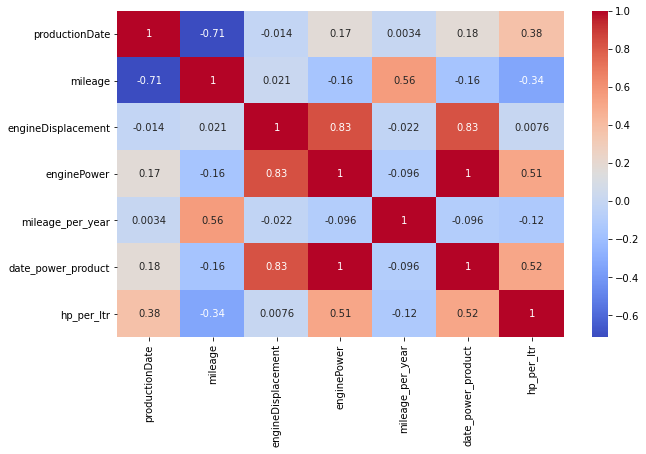

In [54]:
# Correlation again
correlation = cars[num_col].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

High correlation between new features and its parents that was expected. Let's keep it as of now, them models will be tested with and without them.

In [55]:
# Here is the option to remove most correlated or less significant columns with example. If commented - no need to apply

cars = cars.drop(['enginePower', 'engineDisplacement'], axis=1)
cars

,bodyType,brand,color,model_name,vehicleTransmission,productionDate,drive_unit,mileage,wheel,fuelType,vendor,sample,premium,mileage_per_year,date_power_product,hp_per_ltr
0,внедорожник 5 дв.,AUDI,красный,Q3,роботизированная,2014,полный,39672,Левый,бензин,EUROPEAN,1,1,4959,342380.0,8.500000
1,внедорожник 5 дв.,AUDI,белый,Q3,роботизированная,2012,полный,104500,Левый,бензин,EUROPEAN,1,1,10450,424532.0,10.550000
2,внедорожник 5 дв.,AUDI,чёрный,Q7,автоматическая,2011,полный,78000,Левый,дизель,EUROPEAN,1,1,7090,1005500.0,8.474576
3,внедорожник 5 дв.,AUDI,чёрный,Q8,автоматическая,2018,полный,21464,Левый,бензин,EUROPEAN,1,1,5366,686120.0,11.333333
4,лифтбек,AUDI,чёрный,A5,роботизированная,2015,полный,111500,Левый,бензин,EUROPEAN,1,1,15928,453375.0,11.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156415,седан,BMW,коричневый,3,автоматическая,2014,задний,115000,Левый,бензин,EUROPEAN,0,1,14375,273904.0,8.500000
156416,седан,BMW,чёрный,5,автоматическая,2018,полный,98000,Левый,дизель,EUROPEAN,0,1,24500,383420.0,9.500000
156417,седан,BMW,серый,5,автоматическая,1997,задний,360000,Левый,бензин,EUROPEAN,0,1,14400,339490.0,6.800000
156418,внедорожник 5 дв.,BMW,коричневый,X1,автоматическая,2013,полный,90500,Левый,дизель,EUROPEAN,0,1,10055,370392.0,9.200000


In [56]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156420 entries, 0 to 156419
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             156420 non-null  object 
 1   brand                156420 non-null  object 
 2   color                156420 non-null  object 
 3   model_name           156420 non-null  object 
 4   vehicleTransmission  156420 non-null  object 
 5   productionDate       156420 non-null  int64  
 6   drive_unit           156420 non-null  object 
 7   mileage              156420 non-null  int64  
 8   wheel                156420 non-null  object 
 9   fuelType             156420 non-null  object 
 10  vendor               156420 non-null  object 
 11  sample               156420 non-null  int64  
 12  premium              156420 non-null  int64  
 13  mileage_per_year     156420 non-null  int64  
 14  date_power_product   156420 non-null  float64
 15  hp_per_ltr       

## Categorical variables encoding

In [57]:
# Make cat columns discrete
for col in cat_col:
    cars[col] = cars[col].astype('category').cat.codes

In [58]:
cars

,bodyType,brand,color,model_name,vehicleTransmission,productionDate,drive_unit,mileage,wheel,fuelType,vendor,sample,premium,mileage_per_year,date_power_product,hp_per_ltr
0,1,0,7,432,3,2014,2,39672,0,0,0,1,1,4959,342380.0,8.500000
1,1,0,1,432,3,2012,2,104500,0,0,0,1,1,10450,424532.0,10.550000
2,1,0,15,437,0,2011,2,78000,0,3,0,1,1,7090,1005500.0,8.474576
3,1,0,15,439,0,2018,2,21464,0,0,0,1,1,5366,686120.0,11.333333
4,8,0,15,42,3,2015,2,111500,0,0,0,1,1,15928,453375.0,11.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156415,15,1,6,13,0,2014,0,115000,0,0,0,0,1,14375,273904.0,8.500000
156416,15,1,15,24,0,2018,2,98000,0,3,0,0,1,24500,383420.0,9.500000
156417,15,1,12,24,0,1997,0,360000,0,0,0,0,1,14400,339490.0,6.800000
156418,1,1,6,650,0,2013,2,90500,0,3,0,0,1,10055,370392.0,9.200000


In [59]:
# Standartize num_col
data = cars.drop(cat_col + ['sample'], axis=1)
scaler = StandardScaler()
data = scaler.fit_transform(data)
cars[cars.drop(cat_col  + ['sample'], axis=1).columns] = data
cars

,bodyType,brand,color,model_name,vehicleTransmission,productionDate,drive_unit,mileage,wheel,fuelType,vendor,sample,premium,mileage_per_year,date_power_product,hp_per_ltr
0,1,0,7,432,3,0.376855,2,-1.009239,0,0,0,1,1,-1.233103,-0.221361,0.319986
1,1,0,1,432,3,0.053909,2,-0.283124,0,0,0,1,1,-0.343542,0.208032,1.417567
2,1,0,15,437,0,-0.107564,2,-0.579941,0,3,0,1,1,-0.887873,3.244647,0.306374
3,1,0,15,439,0,1.022747,2,-1.213180,0,0,0,1,1,-1.167167,1.575305,1.836968
4,8,0,15,42,3,0.538328,2,-0.204720,0,0,0,1,1,0.543913,0.358789,1.792350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156415,15,1,6,13,0,0.376855,0,-0.165517,0,0,0,0,1,0.292321,-0.579273,0.319986
156416,15,1,15,24,0,1.022747,2,-0.355928,0,3,0,0,1,1.932606,-0.006853,0.855392
156417,15,1,12,24,0,-2.368187,0,2.578638,0,0,0,0,1,0.296371,-0.236467,-0.590202
156418,1,1,6,650,0,0.215382,2,-0.439933,0,3,0,0,1,-0.407533,-0.074948,0.694770


In [60]:
# Split back train and test 
train = cars.query('sample == 1').drop(['sample'], axis=1)
test = cars.query('sample == 0').drop(['sample'], axis=1)

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121734 entries, 0 to 121733
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             121734 non-null  int8   
 1   brand                121734 non-null  int8   
 2   color                121734 non-null  int8   
 3   model_name           121734 non-null  int16  
 4   vehicleTransmission  121734 non-null  int8   
 5   productionDate       121734 non-null  float64
 6   drive_unit           121734 non-null  int8   
 7   mileage              121734 non-null  float64
 8   wheel                121734 non-null  int8   
 9   fuelType             121734 non-null  int8   
 10  vendor               121734 non-null  int8   
 11  premium              121734 non-null  int8   
 12  mileage_per_year     121734 non-null  float64
 13  date_power_product   121734 non-null  float64
 14  hp_per_ltr           121734 non-null  float64
dtypes: float64(5), in

In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 121734 to 156419
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  int8   
 1   brand                34686 non-null  int8   
 2   color                34686 non-null  int8   
 3   model_name           34686 non-null  int16  
 4   vehicleTransmission  34686 non-null  int8   
 5   productionDate       34686 non-null  float64
 6   drive_unit           34686 non-null  int8   
 7   mileage              34686 non-null  float64
 8   wheel                34686 non-null  int8   
 9   fuelType             34686 non-null  int8   
 10  vendor               34686 non-null  int8   
 11  premium              34686 non-null  int8   
 12  mileage_per_year     34686 non-null  float64
 13  date_power_product   34686 non-null  float64
 14  hp_per_ltr           34686 non-null  float64
dtypes: float64(5), int16(1), int8(

In [63]:
# Apply train/test split (FOR TRAIN DATASET ONLY)
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 4. Models

## 4.1 CatBoost

In [64]:
# Add some variables to use in model params
ITERATIONS = 8000
LR = 0.15 #learning rate

In [65]:
model = CatBoostRegressor(iterations = ITERATIONS,
                         learning_rate = LR,
                         random_seed = RANDOM_SEED,
                         eval_metric='MAPE',
                         custom_metric=['R2', 'MAE']
                        )
model.fit(X_train, y_train,
        #cat_features=cat_features_ids,
        eval_set=(X_test, y_test),
        verbose_eval=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3137612	test: 1.3085450	best: 1.3085450 (0)	total: 116ms	remaining: 15m 26s
100:	learn: 0.1716451	test: 0.1708810	best: 0.1708810 (100)	total: 1.87s	remaining: 2m 26s
200:	learn: 0.1395721	test: 0.1402369	best: 0.1402369 (200)	total: 3.35s	remaining: 2m 9s
300:	learn: 0.1221715	test: 0.1236080	best: 0.1236080 (300)	total: 5.21s	remaining: 2m 13s
400:	learn: 0.1132027	test: 0.1154235	best: 0.1154235 (400)	total: 7.04s	remaining: 2m 13s
500:	learn: 0.1055948	test: 0.1087186	best: 0.1087186 (500)	total: 8.91s	remaining: 2m 13s
600:	learn: 0.0993333	test: 0.1030455	best: 0.1030455 (600)	total: 10.8s	remaining: 2m 12s
700:	learn: 0.0949867	test: 0.0992117	best: 0.0992117 (700)	total: 12.6s	remaining: 2m 11s
800:	learn: 0.0911644	test: 0.0960960	best: 0.0960960 (800)	total: 14.5s	remaining: 2m 10s
900:	learn: 0.0876429	test: 0.0930538	best: 0.0930538 (900)	total: 16.5s	remaining: 2m 10s
1000:	learn: 0.0849418	test: 0.0909040	best: 0.0909040 (1000)	total: 18.2s	remaining: 2m 7s
11

In [66]:
# Estimate model with MAPE
predict = model.predict(X_test)
print(f"MAPE: {(mape(y_test, predict))*100:0.2f}%")

MAPE: 6.94%


So, first attempt gives us MAPE = 7%. Let's try to use it with logarithm for target variable

In [67]:
model = CatBoostRegressor(iterations = ITERATIONS,
                         learning_rate = LR,
                         random_seed = RANDOM_SEED,
                         eval_metric='MAPE',
                         custom_metric=['R2', 'MAE']
                        )
model.fit(X_train, np.log(y_train),
        #cat_features=cat_features_ids,
        eval_set=(X_test, np.log(y_test)),
        verbose_eval=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0439546	test: 0.0443010	best: 0.0443010 (0)	total: 18.8ms	remaining: 2m 30s
100:	learn: 0.0089255	test: 0.0090150	best: 0.0090150 (100)	total: 1.82s	remaining: 2m 22s
200:	learn: 0.0075415	test: 0.0077082	best: 0.0077082 (200)	total: 3.63s	remaining: 2m 20s
300:	learn: 0.0067679	test: 0.0070015	best: 0.0070015 (300)	total: 5.45s	remaining: 2m 19s
400:	learn: 0.0062947	test: 0.0065938	best: 0.0065938 (400)	total: 7.17s	remaining: 2m 15s
500:	learn: 0.0059210	test: 0.0062790	best: 0.0062790 (500)	total: 8.99s	remaining: 2m 14s
600:	learn: 0.0056409	test: 0.0060573	best: 0.0060573 (600)	total: 10.6s	remaining: 2m 10s
700:	learn: 0.0054060	test: 0.0058624	best: 0.0058624 (700)	total: 12.6s	remaining: 2m 10s
800:	learn: 0.0052351	test: 0.0057412	best: 0.0057412 (800)	total: 14.4s	remaining: 2m 9s
900:	learn: 0.0050661	test: 0.0056181	best: 0.0056180 (899)	total: 16.3s	remaining: 2m 8s
1000:	learn: 0.0049119	test: 0.0055067	best: 0.0055067 (1000)	total: 18.3s	remaining: 2m 7s
110

In [68]:
predict_test = np.exp(model.predict(X_test))
print(f"MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

MAPE: 6.11%


In [69]:
predict_submission = np.exp(model.predict(test))

In [70]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission.csv', index=False)

The result is a bit better but not significantly. Kaggle score = 17.17 Let's try other models

## 4.2 RandomForest

In [71]:
# Model setup
rf = RandomForestRegressor(random_state=RANDOM_SEED)

# GridSearch optimization with some parameters TOO LONG TO GET PARAMS, LET'S USE STANDARD RF

# n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
#                                cv=3, verbose=2, random_state=42, n_jobs=-1)
# rf_random.fit(X_train, y_train)

# print(rf_random.best_params_)

In [72]:
rf.fit(X_train, np.log(y_train))
predict_test = np.exp(rf.predict(X_test))
print(f"MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

MAPE: 6.25%


In [73]:
# No any improvements with random forest, let's try to change params randomly
rf = RandomForestRegressor(
 n_estimators=300, 
 min_samples_split=2,
 min_samples_leaf=1,
 max_features=10,
 max_depth=89,
 bootstrap=True, 
 random_state=42)

rf.fit(X_train, np.log(y_train))
predict_test = np.exp(rf.predict(X_test))
print(f"MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

MAPE: 6.08%


In [74]:
# All models show better result with logarithm on target variable. Here it' been fixed
y_train = np.log(y_train)

In [75]:
# Submit the results
predict_submission = np.exp(rf.predict(test))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_forest.csv', index=False)

Kaggle result 16.94

## 4.3 Bagging

In [76]:
# One tree
tree = DecisionTreeRegressor(max_features='sqrt')
tree.fit(X_train, y_train)
test_predict = np.exp(tree.predict(X_test))
print(f"DecisionTreeRegressor Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

DecisionTreeRegressor Test MAPE: 9.578%


In [77]:
# Bagging trees
bagging_trees = BaggingRegressor(tree, n_estimators=100)
bagging_trees.fit(X_train, y_train)
test_predict = np.exp(bagging_trees.predict(X_test))
print(f"BaggingRegressor(DecisionTrees) Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

BaggingRegressor(DecisionTrees) Test MAPE: 6.138%


The result according to MAPE is close to the best one, but still more than 6. Move to the next model

## 4.4 GradientBoosting, Extra Trees

In [78]:
# Use with random params
boosting = GradientBoostingRegressor(max_depth=6,n_estimators=1500,learning_rate=0.1,random_state=RANDOM_SEED)
boosting.fit(X_train, y_train)
test_predict = np.exp(boosting.predict(X_test))
print(f"GradientBoosting MAPE: {mape(y_test, test_predict)*100:0.3f}%")

GradientBoosting MAPE: 6.486%


In [79]:
# Same for Extra Trees
trees = ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=RANDOM_SEED)
trees.fit(X_train, y_train)
test_predict = np.exp(trees.predict(X_test))
print(f"ExtraTrees MAPE: {mape(y_test, test_predict)*100:0.3f}%")

ExtraTrees MAPE: 6.242%


Both show higher MAPE scores

## 4.5 XGboost

In [80]:
# Additional imports
import xgboost as xgb

# XG with random params
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 3000)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
test_predict = np.exp(xg_reg.predict(X_test))
print(f"XGBoost MAPE: {mape(y_test, test_predict)*100:0.3f}%")

XGBoost MAPE: 7.444%


As we can see gradient boosting models in general show worse result than Random Forest

## 4.6 LGBMRegressor

In [82]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [83]:
# Regressor with random params
# LGBMR = LGBMRegressor(objective='regression', max_depth=100, num_leaves=1000,
#                       learning_rate=0.02, n_estimators=20000, metric='mape',                      
#                       feature_fraction=0.6)

# LGBMR.fit(X_train, y_train)
# test_predict = np.exp(LGBMR.predict(X_test))
# print(f"LGBMR MAPE: {mape(y_test, test_predict)*100:0.3f}%")

In [84]:
# Gives not appropriate MAPE, no submission

## Back to RandomForest

In [85]:
# RF gives the best score as of now, Grid search takes too long to search for best parameters. 
# Trying to find some params manually, here is the best model found below

rf = RandomForestRegressor(
 n_estimators=2000, 
 min_samples_split=5,
 min_samples_leaf=1,
 max_features=10,
 max_depth=90,
 bootstrap=True, 
 random_state=42)

rf.fit(X_train, y_train)
predict_test = np.exp(rf.predict(X_test))
print(f"MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

MAPE: 6.02%


In [88]:
predict_submission = np.exp(rf.predict(test))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_forest_2.csv', index=False)

Current kaggle score 16.84716 is the best

In [162]:
X = train.values
y = y.values

In [168]:
# Cross validation
def rf_model(y_train, X_train, X_test, y_test):
    model = RandomForestRegressor(
                 n_estimators=2000,
                 min_samples_split=5,
                 min_samples_leaf=1,
                 max_features=10,
                 max_depth=90,
                 bootstrap=True, 
                 random_state=42)
    model.fit(X_train, y_train)
    return(model)
N_FOLDS = 5
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X,y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    Xf_train, yf_train, Xf_test, yf_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    # model for this fold
    model = rf_model(yf_train, Xf_train, Xf_test, yf_test)
    # score model on test
    test_predict = model.predict(Xf_test)
    test_score = mape(yf_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test, test_predict)*100:0.4f}%")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(test)
    
print(f'Mean Score: {np.mean(score_ls)*100:0.4f}%')
print(f'Std Score: {np.std(score_ls)*100:0.4f}%')
print(f'Max Score: {np.max(score_ls)*100:0.4f}%')
print(f'Min Score: {np.min(score_ls)*100:0.4f}%')

1 Fold Test MAPE: 6.7037%
2 Fold Test MAPE: 6.9390%
3 Fold Test MAPE: 6.8799%


4 Fold Test MAPE: 6.8127%
5 Fold Test MAPE: 6.9332%

Mean Score: 6.8537%
Std Score: 0.0877%
Max Score: 6.9390%
Min Score: 6.7037%


# Stacking

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [173]:
# Take formulas from the course 

def compute_meta_feature(regr, X_train, X_test, y_train, cv, X_pred):    
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)
    
    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)
    
    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(X_pred)
    
    return X_meta_train, X_meta_test, X_meta_pred

# Meta-features generation 
def generate_meta_features(regr, X_train, X_test, y_train, cv, X_pred):
   
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv, X_pred) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack([features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

In [174]:
# K-fold and metrics function
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def compute_metric(regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    regr.fit(X_train, y_train)
    predict_test = np.exp(rf.predict(X_test))
    return np.round(mape(y_test, predict_test)*100, 4)

In [ ]:
# Stack RandomForest and ExtraTrees as the best models and add AdaBoost
stacked_features_train, stacked_features_test, stacked_features_pred= generate_meta_features([
    RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                          max_features=7,max_depth=90, bootstrap=True, random_state=42),
    AdaBoostRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    RandomForestRegressor(random_state=42)], X_train, X_test, y_train, cv, test)

# Random forest as meta regressor
regr = RandomForestRegressor(
 n_estimators=300,
 min_samples_split=5,
 min_samples_leaf=1,
 max_features=10,
 max_depth=90,
 bootstrap=True, 
 random_state=42)

print(f'Stacking MAPE = {compute_metric(regr, X_train=stacked_features_train, y_train=y_train.reshape(-1,1), X_test=stacked_features_test, y_test=y_test.reshape(-1,1))}%')

# Conclusion

1. More than 130000 cars collected from auto.ru
2. Parsing could be better if auto.ru allows me to see json respond, but it wasn't found in network --> XHR as usual
3. There were some outliers, but if I remove them I'll get worse results on Kaggle, because it couldn't catch, for example, cars in test with old production date
4. Several models were created, RandomForest gives best score. If take more time I would apply GridSearch to find best params
5. Result on Kaggle is average among other submissions.
6. Main focus was to see how different models perform, but in real life I would take more time for EDA and feature engineering

P.S. Didn't find a team to work with:( but used some best practices I found in Internet and kaggle, so I would say it was my virtual team:)

There is away far from ideal result, but we're all learning!